# Nonholonomic RRT 

by Emmy Chow

This report has consulted the following resources:

[RRT Implementation for Non-holonomic Robot (Part 2 - for car-like robots](https://www.linkedin.com/pulse/rrt-implementation-non-holonomic-robot-part-2-car-like-ankit-saini)

[Nonholonomic Mobile Robot Motion Planning](http://msl.cs.uiuc.edu/~lavalle/cs576_1999/projects/junqu/)

[RRT Path Planning using a Dynamic Vehicle Model](https://www.cs.cmu.edu/~motionplanning/reading/rosssiddpresentation.pdf)

I felt that a Jupyter Notebook would be the best way to explain and discuss the techniques used.

## Objectives

I aimed to construct a nonholonomic RRT with the kinematics of a car. Nonholonomic means that unlike traditional RRT, the tree cannot construct paths in arbitrary directions. The path generated must be one that is kinematically feasible for a vehicle with car-like dynamics.

In [ ]:
import matplotlib.pyplot as plt
from mtree import MTree
from src.rrtutil import dist, dist2, diff
import numpy as np


class RRTNode(ndarray):
    def __new__(cls, arr: ArrayLike):
        n = asarray(arr).view(cls)
        return (n)

    # This is how you add properties to ndarray subclasses evidently.
    def __array_finalize__(self, obj):
        if obj is not None:
            # [phi, v, (start_t_idx, stop_t_idx), phi_idx]
            self.u = getattr(obj, 'u', [None] * 4)
            self.parent = getattr(obj, 'parent', None)

            # Deques have O(1) insertion at the end, no reallactions necessary!
            self.children = getattr(obj, 'children', deque())




def rotate(n, theta):
    """
    Equivalent to (but faster than)
    R = np.array([
        [np.cos(theta), -np.sin(theta)],
        [np.sin(theta), np.cos(theta)]
    ])

    n[:2] = R @ n[:2]

    return(n)
    """

    c = np.cos(theta)
    s = np.sin(theta)
    
    n0 = n[0].copy()
    n1 = n[1].copy()

    n[0] = n0 * c - n1 * s
    n[1] = n0 * s + n1 * c

    return(n)

## Approach

### Optimizing KNN Search

Going by the discussion in checkpoint 1, it was clear that optimizations would be necessary in order to perform any more intensive tasks using RRT. The first step in this process was doing performance profiling.

Various functions were profiled and it was shown that animating the tree’s construction and rebalancing the KDTree took up the most amount of time. 

Animation was slowed to 15 FPS from 120 FPS, which improved performance by a factor of 2. Further analysis showed that visualizing RRT nodes also slowed down the graphics considerably since thousands would need to be rendered at a time including line segments. This would cause the animation to start and stop abruptly as memory processes happened in the background; therefore, it was logical to remove this visualization and only show the nodes for a path to the goal.

Research online showed that KDTrees are not suitable for the addition of nodes; therefore, a new data structure was sought.

The solution came in the form of an MTree (or Metric Tree). These trees are a modern variant of KDTrees and work well for any metric satisfying the triangle inequality. Tests were performed and showed the new algorithm performed 2-3 times faster than KDTrees. While 3 DOF was still difficult for 3% tolerance, it operated more consistently.

I originally used [tburette's mtree implementation in Python](https://github.com/tburette/mtree); however, this contained several bugs, which I have since [patched in a fork](https://github.com/EmDash00/mtree). This version is used in the code I present in this report.


### Speeding solution convergence

[Nonholonomic Mobile Robot Motion Planning](http://msl.cs.uiuc.edu/~lavalle/cs576_1999/projects/junqu/) suggested "Goal-Region biased sampling". In this sampling regime, we sample a region around the goal with a probability. The region shrinks around the goal over time ensuring smarter sampling; however, I believe this could be improved.

I also varied the probability that the goal is sampled over time. The probablity to sample the goal is defined to be the ratio of the tolerance to the best distance to the goal. This gives a crude explore vs. exploit behavior to the algorithm. In the beginning, it explores more often; however, as it closes in the goal, it samples aggressively around the goal to converge to a solution.

This is incredibly effective and allows quick convergence to tolerances of 1% in 3 DOF in under a minute.


### Incorporating Kinematics

First it was necessary to determine the kinematics of a car. [Nonholonomic Mobile Robot Motion Planning](http://msl.cs.uiuc.edu/~lavalle/cs576_1999/projects/junqu/) had previously determined this, so I went off the equations listed. In particular:

$$ \dot{x} = v \cos(\phi) \cos(\theta) $$

$$ \dot{y} = v \cos(\phi) \sin(\theta) $$

$$ \dot{\theta} = \theta \frac{v}{L}\sin(\phi) $$

where $(x, y)$ is the position of the robot in space, $\theta$ is its heading, $\phi$ is the prescribed steering angle, $v$ is the linear velocity of the robot, and $L$ is the length of the robot (the distance between the front and back wheels).

At the suggestion of [Nonholonomic Mobile Robot Motion Planning](http://msl.cs.uiuc.edu/~lavalle/cs576_1999/projects/junqu/), we use a method called motion primatives. This method starts similar to RRT. We sample a random node in the configuration space and then select the nearest neighbor in the tree using KNN search; however, we can no longer directly extend the tree in the direction of the sampled point. Instead, we can integrate the equations of motion at each step to determine possible futures with different steering angles. We then extend in the direction of the primative that matches most closely to the sampled point.

The equations derived earlier suggest that we can determine possible future locations and thus generate motion primatives via numerical integration. In particular, I chose Forward Euler integration for its simplicity. While more accurate and robust methods such as RK4 can be employed for numerical integration, I considered it to be outside the scope of this project.

We now arrive at the Forward-Euler equations.

$$ x_{i + 1} = x_i + v \cos(\phi) \cos(\theta)\Delta t $$

$$ y_{i + 1} = y_i + v \cos(\phi) \sin(\theta)\Delta t $$

$$ \theta_{i + 1} = \theta_i + \theta \frac{v}{L}\sin(\phi)\Delta t $$

While [Nonholonomic Mobile Robot Motion Planning](http://msl.cs.uiuc.edu/~lavalle/cs576_1999/projects/junqu/) only employed velocities of +1 and -1, I felt like having the velocity vary proportional to the distance would more closely match the original RRT algorithm, which extends a length proportional to the distance to the nearest node in the tree to the sampled point.

### Generating Geometric Primatives

In the code, the geometric primatives are stored as a 4 dimensional array. Each configuration is a array of $(x, y, \theta)$ and varies over the steering angles, velocities, and time. Below, I use Forward-Euler to generate many primatives for a starting point of $(0, 0, 0)$

In [388]:
from numpy import pi

L = 0.05
v_max = 5
T = 0.1  # Amount of time to simulate into the future

N_phi = 21  # Number of turning angles to generate
N_t = 10  # Resolution of Euler integration
N_v = 500

phi = np.linspace(-0.4 * np.pi, 0.4 * np.pi, N_phi)
primatives = np.zeros((N_t, N_v, N_phi, 3))
neg_prim = np.zeros_like(primatives)

primatives[0] = 0

dt = T / N_t

for i in range(N_v):
    v = i * v_max / N_v

    for j in range(1, N_t):
        primatives[j, i, :, 0] = (
            primatives[j - 1, i, :, 0] + 
            v * np.cos(phi) * np.cos(primatives[j - 1, i, :, 2] * pi) * dt
        )

        primatives[j, i, :, 1] = (
            primatives[j - 1, i, :, 1] + 
            v * np.cos(phi) * np.sin(primatives[j - 1, i, :, 2] * pi) * dt
        )

        primatives[j, i, :, 2] = (
            primatives[j - 1, i, :, 2] + 
            v / L * np.sin(phi) / (pi) * dt
        )

#primatives[..., 2] -= np.floor(primatives[..., 2])
neg_prim[..., :2] = -primatives[..., :2]
neg_prim[..., 2] = primatives[..., 2] + 1
        
candidates = primatives[-1]
neg_candidates = neg_prim[-1]

In [399]:
prims = np.concatenate((primatives, neg_prim))

primative_tree = [MTree(dist) for i in range(500)]

for i in range(N_v):
    v = i * v_max / N_v
    for j in range(N_phi):
        n = RRTNode(primatives[-1, i, j])
        n.u[0] = phi[j]
        n.u[1] = v

        n.u[2] = primatives[:, i, j]
        n.u[3] = i

        primative_tree[i].add(n)

        n_neg = RRTNode(neg_prim[-1, i, j])
        n_neg.u[0] = phi[j]
        n_neg.u[1] = -v

        n_neg.u[2] = neg_prim[:, i, j]
        n_neg.u[3] = i

        primative_tree[i].add(n_neg)

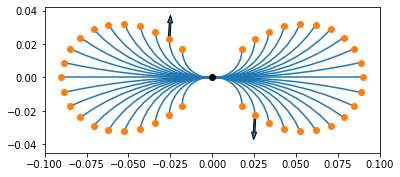

In [400]:
fig, ax = plt.subplots(subplot_kw={'aspect': 'equal'})
ax.set_xlim([-0.1, 0.1])
ax.set_ylim([-0.045, 0.042])

idx = 100

for i in range(primatives.shape[2]):
    ax.plot(primatives[:, idx, i, 0], primatives[:, idx, i, 1], 'C0')
    ax.plot(neg_prim[:, idx, i, 0], neg_prim[:, idx, i, 1], 'C0')

ax.plot(0, 0, 'ko')

ax.plot(candidates[idx, :, 0],  candidates[idx, :, 1], 'C1o')
ax.plot(neg_candidates[idx, :,  0],  neg_candidates[idx, :, 1], 'C1o')

c_idx = 1

dx = np.cos(candidates[idx, c_idx, 2] * pi) / 100
dy = np.sin(candidates[idx, c_idx, 2] * pi) / 100

ax.arrow(candidates[idx, c_idx, 0], candidates[idx, c_idx, 1], dx, dy)

dx = np.cos(neg_candidates[idx, c_idx, 2] * pi) / 100
dy = np.sin(neg_candidates[idx, c_idx, 2] * pi) / 100

ax.arrow(neg_candidates[idx, c_idx, 0], neg_candidates[idx, c_idx, 1], dx, dy)

plt.show()

### Optimizing the Integration Step

Integrating at each step presents a huge cost. However, notice that at every step of the process, we can transform all points so that the nearest neighbor becomes $(0, 0, 0)$. In a sense, we're viewing everything from the reference frame of the nearest neighbor in the tree. This is a bit confusing in words, so I demonstrate this visually below.

In [424]:
p = np.array([0.6, 0.4, 0.1])
n = np.array([0.63, 0.47, 0.2])

x = rotate(diff(n, p), -p[2] * 2 * pi)
n_primative = primative_tree[idx].search(x, 10)[0].obj  # nearest primative

print(x)
print(n_primative)

[0.06541548 0.03899763 0.1       ]
[0.0886559  0.00891913 0.07181065]


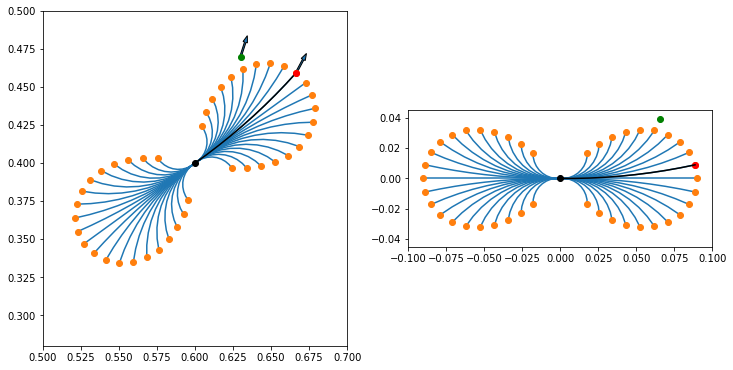

In [425]:
fig, ax = plt.subplots(1, 2, subplot_kw={'aspect': 'equal'}, figsize=(12, 9))

ax[0].set_xlim([-0.1 + p[0], 0.1 + p[0]])
ax[0].set_ylim([0.28, 0.5])

ax[1].set_xlim([-0.1, 0.1])
ax[1].set_ylim([-0.045, 0.045])

for i in range(primatives[:, idx].shape[1]):
    paths = rotate(primatives[:, idx, i, :2].T.copy(), 2 * pi * p[2]).T
    
    ax[0].plot(
        paths[:, 0] + p[0], 
        paths[:, 1] + p[1], 'C0'
    )
    
    ax[0].plot(
        -paths[:, 0] + p[0], 
        -paths[:, 1] + p[1], 'C0'
    )

ax[0].plot(p[0], p[1], 'ko')
ax[0].plot(n[0], n[1], 'go')

path_ends = rotate(candidates[idx, :, :2].T.copy(), 2 * pi * p[2]).T

ax[0].plot(
    path_ends[:, 0] + p[0],  
    path_ends[:, 1] + p[1], 
    'C1o'
)

ax[0].plot(
    -path_ends[:, 0] + p[0],  
    -path_ends[:, 1] + p[1], 
    'C1o'
)

for i in range(primatives[:, idx].shape[1]):
    ax[1].plot(primatives[:, idx, i, 0], primatives[:, idx, i, 1], 'C0')
    ax[1].plot(neg_prim[:, idx, i, 0], neg_prim[:, idx, i, 1], 'C0')

ax[1].plot(0, 0, 'ko')
ax[1].plot(candidates[idx, :, 0],  candidates[idx, :, 1], 'C1o')
ax[1].plot(neg_candidates[idx, :, 0],  neg_candidates[idx, :, 1], 'C1o')

ax[1].plot(x[0], x[1], 'go')
ax[1].plot(n_primative[0], n_primative[1], 'ro')

ax[1].plot(n_primative.u[2][:, 0], n_primative.u[2][:, 1], 'k')
curve = rotate_arc(n_primative.u[2][:, :2].copy(), p[2] * 2 * pi)
soln = rotate(n_primative.copy(), p[2] * 2 * pi)

ax[0].plot(curve[:, 0] + p[0], curve[:, 1] + p[1], 'k')
ax[0].plot(soln[0] + p[0], soln[1] + p[1], 'ro')

theta = soln[2] + p[2]

dx = np.cos(theta * 2 * pi) / 100
dy = np.sin(theta * 2 * pi) / 100

ax[0].arrow(soln[0] + p[0], soln[1] + p[1], dx, dy)

dx = np.cos(n[2] * 2 * pi) / 100
dy = np.sin(n[2] * 2 * pi) / 100

ax[0].arrow(n[0], n[1], dx, dy)

plt.show()

In the above figures, the green dot is a new sample from the RRT algorithm. The blue lines are paths taken by geometric primatives over 0.1s and the orange dots are the end points of the geometric primatives. The black dot is the a theoretical closest point on the node tree.

We see the same scene viewed from two different reference frames. On the left is what I'll refer to as the fixed world frame anchored at $0, 0, 0)$. On the right, we view the problem from the reference frame of the closest point on the node tree.

In this referene frame, we view ourselves at $(0, 0, 0)$ and everything is rotated by $-\theta$. Likewise, all coordinates are viewed relative to its current position. This is done by subtracting the coordinates and angles. There's a brief caveat with angle subtraction I'll cover shortly, but this idea allows us to only need to generate the primatives once. We can save them in an MTree for fast KNN search.

In [435]:
%%HTML
<iframe width="560" height="315" src="https://www.youtube.com/embed/FJg4Kc1kCQo" title="YouTube video player" frameborder="0" allow="accelerometer; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>